<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [22]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding


### DATASET
Se utiliza el dataset de cuentos de hernandez

In [23]:
with open('hernandez_f_full_texts.pkl', 'rb') as f:
   libros_hernandez = pickle.load(f)

In [24]:
libros_hernandez.head(10)

,link,text_metadata,text
0,https://ciudadseva.com/texto/el-acomodador/,"{'title': 'El acomodador', 'metadata': '[Cuent...",Apenas había dejado la adolescencia me fui a v...
1,https://ciudadseva.com/texto/el-balcon/,"{'title': 'El balcón', 'metadata': '[Cuento - ...",Había una ciudad que a mí me gustaba visitar e...
2,https://ciudadseva.com/texto/el-cocodrilo/,"{'title': 'El cocodrilo', 'metadata': '[Cuento...",En una noche de otoño hacía calor húmedo y yo ...
3,https://ciudadseva.com/texto/el-corazon-verde/,"{'title': 'El corazón verde', 'metadata': '[Cu...","Hoy he pasado, en esta pieza, horas felices. N..."
4,https://ciudadseva.com/texto/el-vestido-blanco/,"{'title': 'El vestido blanco', 'metadata': '[C...",I Yo estaba del lado de afuera del balcón. Del...
5,https://ciudadseva.com/texto/elsa/,"{'title': 'Elsa', 'metadata': '[Cuento - Texto...",I Yo no quiero decir cómo es ella. Si digo que...
6,https://ciudadseva.com/texto/en-gira-con-yaman...,"{'title': 'En gira con Yamandú Rodríguez', 'me...",En el año 32 Yamandú Rodríguez y yo hicimos un...
7,https://ciudadseva.com/texto/la-casa-inundada/,"{'title': 'La casa inundada', 'metadata': '[Cu...",De esos días siempre recuerdo las vueltas en u...
8,https://ciudadseva.com/texto/la-mujer-parecida...,"{'title': 'La mujer parecida a mí', 'metadata'...",Hace algunos veranos empecé a tener la idea de...
9,https://ciudadseva.com/texto/la-pelota/,"{'title': 'La pelota', 'metadata': '[Minicuent...",Cuando yo tenía ocho años pasé una larga tempo...


In [25]:
df = libros_hernandez['text']
df

0     Apenas había dejado la adolescencia me fui a v...
1     Había una ciudad que a mí me gustaba visitar e...
2     En una noche de otoño hacía calor húmedo y yo ...
3     Hoy he pasado, en esta pieza, horas felices. N...
4     I Yo estaba del lado de afuera del balcón. Del...
5     I Yo no quiero decir cómo es ella. Si digo que...
6     En el año 32 Yamandú Rodríguez y yo hicimos un...
7     De esos días siempre recuerdo las vueltas en u...
8     Hace algunos veranos empecé a tener la idea de...
9     Cuando yo tenía ocho años pasé una larga tempo...
10    En mi último año de escuela veía yo siempre un...
11    El día de mi primer concierto tuve sufrimiento...
12    La propaganda de estos muebles me tomó desprev...
13    Hace muchos años, al principio de un verano, y...
14    Hace mucho tiempo leía yo un cuento en una sal...
Name: text, dtype: object

In [26]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 15


In [27]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
df

0     Cuando yo tenía ocho años pasé una larga tempo...
1     El día de mi primer concierto tuve sufrimiento...
2     Apenas había dejado la adolescencia me fui a v...
3     Hace muchos años, al principio de un verano, y...
4     I Yo no quiero decir cómo es ella. Si digo que...
5     Hace algunos veranos empecé a tener la idea de...
6     En una noche de otoño hacía calor húmedo y yo ...
7     Había una ciudad que a mí me gustaba visitar e...
8     Hace mucho tiempo leía yo un cuento en una sal...
9     I Yo estaba del lado de afuera del balcón. Del...
10    De esos días siempre recuerdo las vueltas en u...
11    En mi último año de escuela veía yo siempre un...
12    La propaganda de estos muebles me tomó desprev...
13    Hoy he pasado, en esta pieza, horas felices. N...
14    En el año 32 Yamandú Rodríguez y yo hicimos un...
Name: text, dtype: object

### 1 - Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [29]:
# largo de la secuencia, incluye seq input + word output
train_len = 4
separator = 'sep0000'
corpus = df.str.cat(sep=' ' + separator + ' ')

In [30]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['cuando',
 'yo',
 'tenía',
 'ocho',
 'años',
 'pasé',
 'una',
 'larga',
 'temporada',
 'con',
 'mi',
 'abuela',
 'en',
 'una',
 'casita',
 'pobre',
 'una',
 'tarde',
 'le',
 'pedí']

In [31]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 48492


In [32]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  if separator not in seq:
    text_sequences.append(seq)

In [33]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:90]

[['cuando', 'yo', 'tenía', 'ocho'],
 ['yo', 'tenía', 'ocho', 'años'],
 ['tenía', 'ocho', 'años', 'pasé'],
 ['ocho', 'años', 'pasé', 'una'],
 ['años', 'pasé', 'una', 'larga'],
 ['pasé', 'una', 'larga', 'temporada'],
 ['una', 'larga', 'temporada', 'con'],
 ['larga', 'temporada', 'con', 'mi'],
 ['temporada', 'con', 'mi', 'abuela'],
 ['con', 'mi', 'abuela', 'en'],
 ['mi', 'abuela', 'en', 'una'],
 ['abuela', 'en', 'una', 'casita'],
 ['en', 'una', 'casita', 'pobre'],
 ['una', 'casita', 'pobre', 'una'],
 ['casita', 'pobre', 'una', 'tarde'],
 ['pobre', 'una', 'tarde', 'le'],
 ['una', 'tarde', 'le', 'pedí'],
 ['tarde', 'le', 'pedí', 'muchas'],
 ['le', 'pedí', 'muchas', 'veces'],
 ['pedí', 'muchas', 'veces', 'una'],
 ['muchas', 'veces', 'una', 'pelota'],
 ['veces', 'una', 'pelota', 'de'],
 ['una', 'pelota', 'de', 'varios'],
 ['pelota', 'de', 'varios', 'colores'],
 ['de', 'varios', 'colores', 'que'],
 ['varios', 'colores', 'que', 'yo'],
 ['colores', 'que', 'yo', 'veía'],
 ['que', 'yo', 'veía', 'a

In [34]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[28, 10, 36, 1844],
 [10, 36, 1844, 355],
 [36, 1844, 355, 810],
 [1844, 355, 810, 11],
 [355, 810, 11, 952],
 [810, 11, 952, 1385],
 [11, 952, 1385, 16],
 [952, 1385, 16, 22],
 [1385, 16, 22, 334],
 [16, 22, 334, 7],
 [22, 334, 7, 11],
 [334, 7, 11, 1845],
 [7, 11, 1845, 390],
 [11, 1845, 390, 11],
 [1845, 390, 11, 164],
 [390, 11, 164, 25],
 [11, 164, 25, 525],
 [164, 25, 525, 240],
 [25, 525, 240, 97],
 [525, 240, 97, 11]]

In [35]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 48432


### 3 - Input y target

In [36]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(48432, 3)
(48432,)


In [37]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'y',
 3: 'la',
 4: 'que',
 5: 'a',
 6: 'el',
 7: 'en',
 8: 'me',
 9: 'un',
 10: 'yo',
 11: 'una',
 12: 'se',
 13: 'no',
 14: 'las',
 15: 'los',
 16: 'con',
 17: 'al',
 18: 'había',
 19: 'pero',
 20: 'por',
 21: 'del',
 22: 'mi',
 23: 'ella',
 24: 'como',
 25: 'le',
 26: 'lo',
 27: 'para',
 28: 'cuando',
 29: 'él',
 30: 'después',
 31: 'era',
 32: 'su',
 33: 'si',
 34: 'estaba',
 35: 'más',
 36: 'tenía',
 37: 'dijo',
 38: 'entonces',
 39: 'agua',
 40: 'noche',
 41: 'es',
 42: 'mis',
 43: 'ya',
 44: 'ojos',
 45: 'mí',
 46: 'cabeza',
 47: 'otro',
 48: 'sus',
 49: 'luz',
 50: 'sin',
 51: 'casa',
 52: 'pronto',
 53: 'poco',
 54: 'muy',
 55: 'señora',
 56: 'también',
 57: 'amigo',
 58: 'esa',
 59: 'otra',
 60: 'todo',
 61: 'nos',
 62: 'hacía',
 63: 'iba',
 64: 'vez',
 65: 'antes',
 66: 'cara',
 67: 'entre',
 68: 'hasta',
 69: 'ahora',
 70: 'tiempo',
 71: 'vi',
 72: 'ese',
 73: 'qué',
 74: 'margarita',
 75: 'gran',
 76: 'manos',
 77: 'usted',
 78: 'día',
 79: 'porque',
 80: 'fue

In [38]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6417

In [39]:
# Transformar los datos a oneHotEncoding
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [40]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [41]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(48432, 6417)

### 4 - Entrenar el modelo

In [42]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [43]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6417

In [44]:
# # Si existe modelo previo, cargarlo. Buscar en path ./models/modelo_borges_cortazar_0.088.pkl
# import os

# if os.path.isfile('./models/modelo_borges_cortazar_0.088.pkl'):
#    model = pickle.load(open('./models/modelo_borges_cortazar_0.088.pkl', 'rb'))

# if os.path.isfile('./models/tokenizer_borges_cortazar_0.088.pkl'):
#    tok = pickle.load(open('./models/tokenizer_borges_cortazar_0.088.pkl', 'rb'))


In [45]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 15002 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=15, input_length=input_seq_len))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(256)) # La última capa LSTM no lleva return_sequences
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 15002 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 15)             96270     
                                                                 
 lstm (LSTM)                 (None, 256)               278528    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 6417)              1649169   
                                                                 
Total params: 2089759 (7.97 MB)
Trainable params: 2089759 (7.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
hist = model.fit(x_data, y_data, epochs=10, validation_split=0.2)

Epoch 1/10
1211/1211 [==============================] - 73s 61ms/step - loss: 5.9864 - accuracy: 0.0678 - val_loss: 6.5945 - val_accuracy: 0.0652
Epoch 2/10
1211/1211 [==============================] - 73s 60ms/step - loss: 5.6841 - accuracy: 0.0846 - val_loss: 6.6944 - val_accuracy: 0.0833
Epoch 3/10
1211/1211 [==============================] - 73s 61ms/step - loss: 5.4024 - accuracy: 0.1067 - val_loss: 6.7605 - val_accuracy: 0.0895
Epoch 4/10
1211/1211 [==============================] - 73s 60ms/step - loss: 5.1339 - accuracy: 0.1224 - val_loss: 7.0025 - val_accuracy: 0.0964
Epoch 5/10
1211/1211 [==============================] - 75s 62ms/step - loss: 4.8876 - accuracy: 0.1369 - val_loss: 7.2346 - val_accuracy: 0.0945
Epoch 6/10
1211/1211 [==============================] - 80s 66ms/step - loss: 4.6640 - accuracy: 0.1503 - val_loss: 7.5443 - val_accuracy: 0.0954
Epoch 7/10
1211/1211 [==============================] - 79s 65ms/step - loss: 4.4612 - accuracy: 0.1639 - val_loss: 7.8704 -

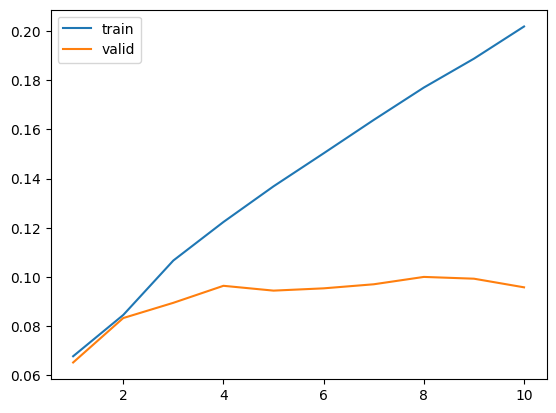

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [49]:
# Guardar modelo entrenado en pkl
with open('./model_hernandez.pkl', 'wb') as f:
    pickle.dump(model, f)

In [50]:
# Guardar el tokenizer
with open('./tokenizer_hernandez', 'wb') as f:
    pickle.dump(tok, f)


In [53]:
# Guardar modelo entrenado en pkl
model.save('./modelo_hernandez',save_format='tf')

INFO:tensorflow:Assets written to: ./modelo_hernandez\assets


INFO:tensorflow:Assets written to: ./modelo_hernandez\assets


### 5 - Predicción de próxima palabra

In [51]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [52]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
# import sys
# !{sys.executable} -m pip install gradio --quiet

In [56]:
import gradio as gr

def model_response(human_text):

    print("Input: " + human_text)

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=train_len-1, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha

    print("Respuesta: " + human_text + ' ' + out_word)

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\typing_extensions.py)

### 6 - Generación de secuencias nuevas

In [57]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [58]:
input_text='un hombre me dio'

generate_seq(model, tok, input_text, max_length=train_len-1, n_words=5)

1/1 [==============================] - 0s 21ms/step


'un hombre me dio apenas de y en a'

### 7 - Beam search y muestreo aleatorio

In [59]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=4):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [62]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if (temp == 1):
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  else:
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp) 

    return history_tokens

In [65]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="habia una vez", temp=1)

1/1 [==============================] - 0s 28ms/step


In [66]:
# veamos las salidas
for salida in salidas:
  print(decode(salida))


['una vez la agua de y de y']
['una vez la permiso de y de y']
['una vez la agua de no en a']
['una vez la agua de y de cómo']
['una vez la agua de y de no']
['una vez la mancha de y de']
['una vez la agua de y de ojos']
['una vez la agua de y de del']
['una vez la permiso de y de me']
['una vez la agua de y de me']


### 8 - Conclusiones
El modelo entrenado tuvo un muy mal desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.